### Medical Imaging Basics

This notebook covers fundamental image processing techniques using Python and key libraries such as `pydicom`, `skimage`, and `matplotlib`. It includes functions to:

- Load and inspect DICOM metadata
- Map pixel values to meaningful units
- Apply windowing for tissue visualisation
- Enhance contrast and adjust intensity
- Identify and measure regions of interest
- Convert DICOM images for analysis
- Visualise and export processed images

Ensure all necessary packages are installed before running the notebook.

### Importing necessary packages and load the dicom data from the existing folders

In [4]:
# Install required packages if not already installed
%pip install -q matplotlib==3.8.2 numpy==1.26.3 pandas==2.2.0 pydicom==3.0.1 scikit-image==0.22.0

print("Necessary packages installed.")

Note: you may need to restart the kernel to use updated packages.
Necessary packages installed.


In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from pydicom import dcmread
from pydicom.pixels import apply_modality_lut, apply_windowing
from skimage import measure, morphology

In [6]:
def load_patient_images(dicom_folder):
    """
    Load all DICOM images from a given patient folder.

    Args:
        dicom_folder (Path): Path to the folder containing DICOM files.

    Returns:
        list: A list of DICOM image arrays sorted by filename.
    """
    dicom_files = sorted([f for f in dicom_folder.iterdir() if f.suffix == ".dcm"])
    return [dcmread(f) for f in dicom_files]

In [7]:
# Define the parent directory containing patient folders
parent_folder = Path("./data")

# Create a dictionary to hold patient datasets
patients_data = {}

# Iterate through each subdirectory (patient folder) and load the data
for path in parent_folder.iterdir():
    if path.is_dir():  # Only consider directories
        patient_name = path.name  # Get the folder name as the patient ID
        print(f"Loading images for {patient_name}...")
        
        # Load the images for this patient
        patient_images = load_patient_images(path)
        
        # Store the dataset in the dictionary
        patients_data[patient_name] = patient_images

        # Print the number of images loaded for this patient
        print(f"{patient_name} data loaded with {len(patient_images)} images.")

Loading images for PatientA...
PatientA data loaded with 248 images.
Loading images for PatientB...
PatientB data loaded with 220 images.


In [8]:
#For easy access for the rest of the tasks

# Lists of DICOM files for Patient A and B
ds_patient_a = patients_data.get('PatientA', [])
ds_patient_b = patients_data.get('PatientB', [])

# Extract pixel_arrays for all DICOM files in each dataset
array_patient_a = [image.pixel_array for image in ds_patient_a]
array_patient_b = [image.pixel_array for image in ds_patient_b]

# Lists of pixel_arrays converted to Hounsfield Units
hu_patient_a = []
for slice_array, ds_slice in zip(array_patient_a, ds_patient_a):
    hu_slice = apply_modality_lut(slice_array, ds_slice)
    hu_patient_a.append(hu_slice)

hu_patient_b = []
for slice_array, ds_slice in zip(array_patient_b, ds_patient_b):
    hu_slice = apply_modality_lut(slice_array, ds_slice)
    hu_patient_b.append(hu_slice)

### Display and windowing of CT images

In [10]:
def apply_window(image_array, dicom_dataset, window_center=-450, window_width=1500):
    """
    Convert pixel data to HU, apply lung windowing, clip values outside the window,
    and then linearly scale the clipped values to the range [0, 1] for display.
    
    Parameters:
      image_array (np.ndarray): The image array from the DICOM dataset.
      dicom_dataset (pydicom.Dataset): The DICOM dataset containing the image.
      window_center (float, optional): The center of the window (default -600 for lung).
      window_width (float, optional): The width of the window (default 1200 for lung).
      
    Returns:
      np.ndarray: The windowed and scaled image ready for display.
    """
    # 1. Convert the pixel data to Hounsfield Units (HU)
    hu_image = apply_modality_lut(image_array, dicom_dataset)
    
    # 2. Calculate the lower and upper bounds for the window.
    lower_bound = window_center - (window_width / 2.0)
    upper_bound = window_center + (window_width / 2.0)
    
    # 3. Clip the HU values to the window range.
    clipped = np.clip(hu_image, lower_bound, upper_bound)
    
    # 4. Scale the clipped values linearly to the range [0, 1] for display.
    # This ensures that lower_bound maps to 0 (black) and upper_bound maps to 1 (white).
    scaled = (clipped - lower_bound) / (upper_bound - lower_bound)
    
    return scaled

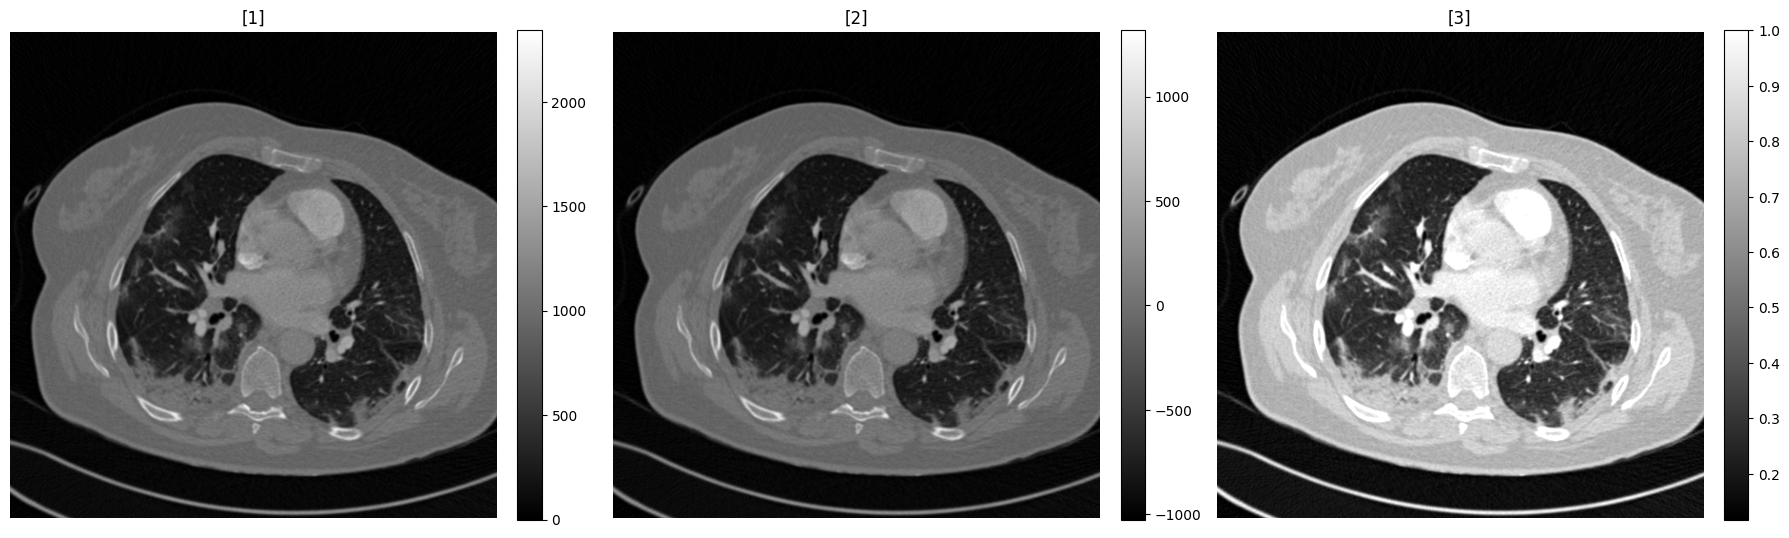

In [11]:
# Select the middle image of Patient A for display as an example
middle_index_a = len(array_patient_a) // 2

ds_middle_image = ds_patient_a[middle_index_a]
array_middle_image = array_patient_a[middle_index_a]
hu_array_middle_image = hu_patient_a[middle_index_a]

middle_image_windowed = apply_window(array_middle_image, ds_middle_image)

# Create figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) Original slice
im0 = axes[0].imshow(array_middle_image, cmap="gray")
axes[0].set_title("[1]")
axes[0].axis("off")
cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
plt.axis("off")

# 2) HU-transformed slice
im1 = axes[1].imshow(hu_patient_a[middle_index_a], cmap="gray")
axes[1].set_title("[2]")
axes[1].axis("off")
cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 3) Windowed HU slice
im2 = axes[2].imshow(middle_image_windowed, cmap="gray")
axes[2].set_title("[3]")
axes[2].axis("off")
cbar2 = fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.savefig("Axial_slice_A_normal_windowed_Task_2_3.png", bbox_inches="tight", pad_inches=0.2, dpi=300)
plt.tight_layout()
plt.show()

### Computing pixel intensity statistics

In [13]:
def calculate_statistics(image_arrays):
    # Flatten all image arrays into a single list of pixel values
    pixel_values = np.concatenate([image.flatten() for image in image_arrays])  # Access pixel_array here
    stats = {
        "Min": np.round(np.min(pixel_values), 3),
        "Max": np.round(np.max(pixel_values), 3),
        "Mean": np.round(np.mean(pixel_values), 3),
        "Std Dev": np.round(np.std(pixel_values), 3)
    }
    return stats

In [14]:
#Calculate pixel statistics for the Patient and a single example image (middle slice of Patient A)
stats_middle_image = calculate_statistics(array_middle_image)
print(f"\nExample Image Patient A: {stats_middle_image}")

stats_patient_a = calculate_statistics(array_patient_a)
print(f"\nAll Images Patient A: {stats_patient_a}")

stats_patient_b = calculate_statistics(array_patient_b)
print(f"\nAll Images Patient B: {stats_patient_b}\n")


#For testing the transformation of apply_windowing and apply_modality_lut
stats_stats_middle_image = calculate_statistics(hu_array_middle_image)
print(f"\nhu_array_middle_image: {stats_stats_middle_image}")

stats_middle_image_windowed = calculate_statistics(middle_image_windowed)
print(f"\nmiddle_image_windowed: {stats_middle_image_windowed}")


Example Image Patient A: {'Min': 0, 'Max': 2341, 'Mean': 553.885, 'Std Dev': 471.872}

All Images Patient A: {'Min': 0, 'Max': 4095, 'Mean': 548.476, 'Std Dev': 489.987}

All Images Patient B: {'Min': -2000, 'Max': 4095, 'Mean': 119.758, 'Std Dev': 1182.469}


hu_array_middle_image: {'Min': -1024.0, 'Max': 1317.0, 'Mean': -470.115, 'Std Dev': 471.872}

middle_image_windowed: {'Min': 0.117, 'Max': 1.0, 'Mean': 0.484, 'Std Dev': 0.309}


### Histograms of pixel values

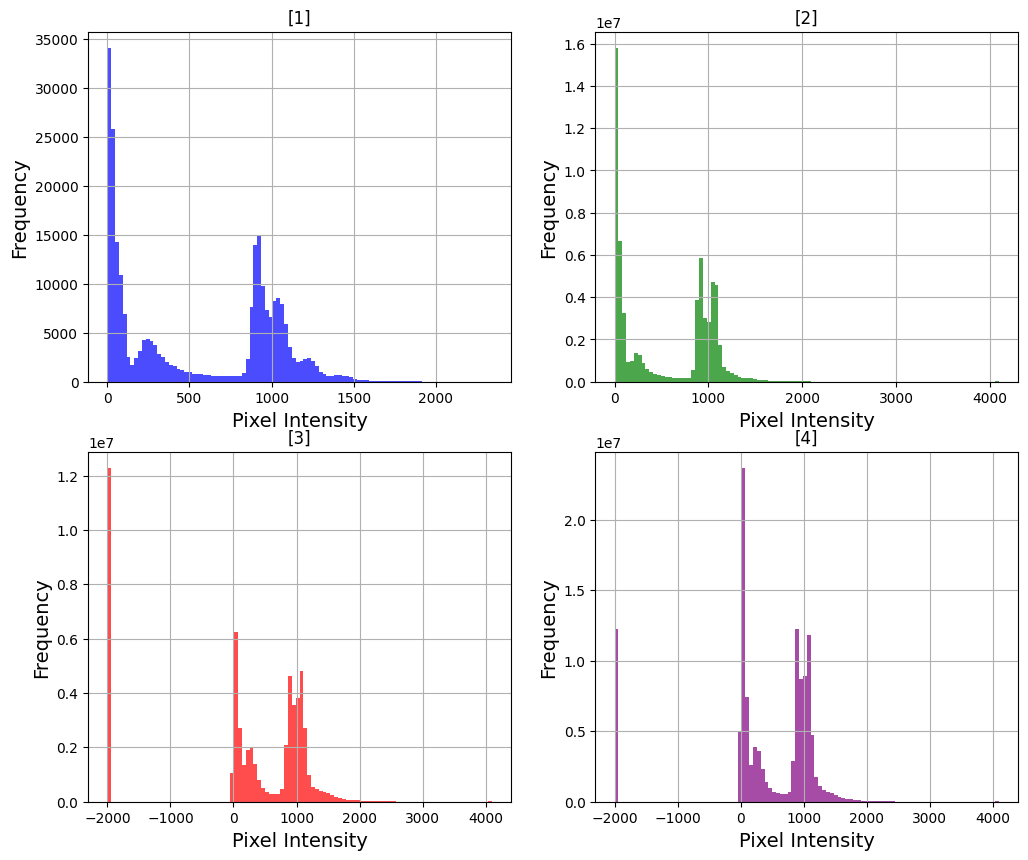

In [16]:
def get_histogram_data(image_arrays):
    # Access pixel_array and flatten the image data
    return np.concatenate([image.flatten() for image in image_arrays])
    
middle_image_data = get_histogram_data(array_middle_image)
all_patient_a_data = get_histogram_data(array_patient_a)
all_patient_b_data = get_histogram_data(array_patient_b)
all_patients_data = get_histogram_data(array_patient_a + array_patient_b)

# Create a 2x2 subplot to display the histograms as a table
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot each histogram
axes[0, 0].hist(middle_image_data, bins=100, color="blue", alpha=0.7)
axes[0, 0].set_title("[1]")
axes[0, 0].set_xlabel("Pixel Intensity", fontsize=14)
axes[0, 0].set_ylabel("Frequency", fontsize=14)
axes[0, 0].grid(True)

axes[0, 1].hist(all_patient_a_data, bins=100, color="green", alpha=0.7)
axes[0, 1].set_title("[2]")
axes[0, 1].set_xlabel("Pixel Intensity", fontsize=14)
axes[0, 1].set_ylabel("Frequency", fontsize=14)
axes[0, 1].grid(True)

axes[1, 0].hist(all_patient_b_data, bins=100, color="red", alpha=0.7)
axes[1, 0].set_title("[3]")
axes[1, 0].set_xlabel("Pixel Intensity", fontsize=14)
axes[1, 0].set_ylabel("Frequency", fontsize=14)
axes[1, 0].grid(True)

axes[1, 1].hist(all_patients_data, bins=100, color="purple", alpha=0.7)
axes[1, 1].set_title("[4]")
axes[1, 1].set_xlabel("Pixel Intensity", fontsize=14)
axes[1, 1].set_ylabel("Frequency", fontsize=14)
axes[1, 1].grid(True)

# Save and display the histograms
plt.savefig("Histograms_pixel_intensity_A_B_Task_4.png", bbox_inches="tight", pad_inches=0.2, dpi=300)
plt.show()

### Reconstructing an image in the coronal plane

In [18]:
def reconstruct_coronal(volume):
    """
    Convert stacked axial slices into coronal slices by slicing along the y-axis.
    This function extracts and returns a list of coronal slices, one for each y-coordinate.
    
    Parameters:
    volume (numpy.ndarray): 3D numpy array representing the stacked axial slices of a patient
    
    Returns:
    list: A list of 2D numpy arrays representing the coronal slices for each y-coordinate
    """
    coronal_slices = []
    for y_index in range(volume.shape[1]):  # Loop over each y-coordinate (left-right slices)
        coronal_slice = volume[:, y_index, :]  # Extract the coronal view for the current y-coordinate
        coronal_slices.append(coronal_slice)
    return coronal_slices

In [19]:
# Convert the 2D numpy arrays into 3D numpy arrays by stacking along the first axis (depth)
volume_patient_a = np.stack(array_patient_a, axis=0)
volume_patient_b = np.stack(array_patient_b, axis=0)

# Reconstruct all the coronal slices for both patients
coronal_array_patient_a = reconstruct_coronal(volume_patient_a)
coronal_array_patient_b = reconstruct_coronal(volume_patient_b)

# Select the middle index in the y-dimension
middle_index_patient_a = len(coronal_array_patient_a) // 2
middle_index_patient_b = len(coronal_array_patient_b) // 2

# Get the coronal slice for the middle y-coordinate
middle_coronal_slice_patient_a = coronal_array_patient_a[middle_index_patient_a]
middle_coronal_slice_patient_b = coronal_array_patient_b[middle_index_patient_b]

# Apply the windowing function to the selected coronal middle slice
middle_coronal_slice_patient_a_windowed = apply_window(middle_coronal_slice_patient_a, ds_middle_image)
middle_coronal_slice_patient_b_windowed = apply_window(middle_coronal_slice_patient_b, ds_middle_image)

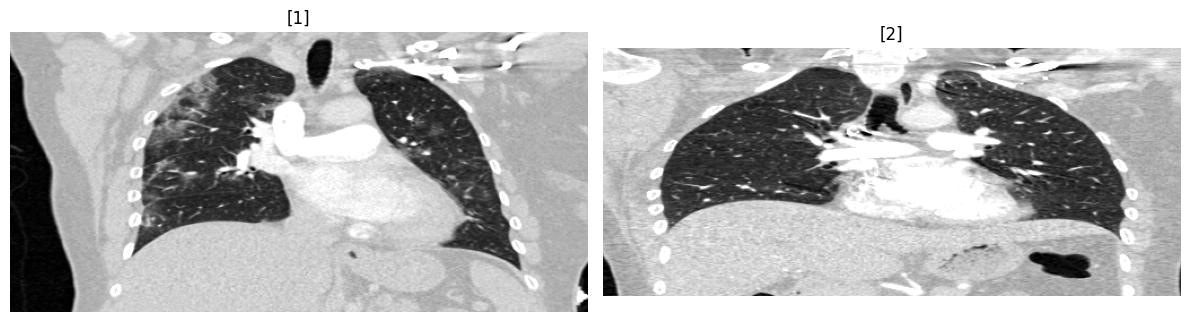

In [20]:
# Display both images next to each other
plt.figure(figsize=(12, 6))

# Patient A's coronal slice
plt.subplot(1, 2, 1)
plt.imshow(middle_coronal_slice_patient_a_windowed, cmap='gray')
plt.title("[1]")
plt.axis("off")

# Patient B's coronal slice
plt.subplot(1, 2, 2)
plt.imshow(middle_coronal_slice_patient_b_windowed, cmap='gray')
plt.title("[2]")
plt.axis("off")

# Save and display the images
plt.tight_layout()
plt.savefig("Coronal_slices_windowed_A_B_Task_6.png", bbox_inches="tight", pad_inches=0.2, dpi=300)
plt.show()

### Generating maximum intensity projection (MIP) coronal and axial view

In [22]:
def compute_mid_mip(image_arrays, num_slices=50):
    """
    Computes a Maximum Intensity Projection (MIP) using 'num_slices'
    slices from the middle of the provided image_arrays list.
    """
    total_slices = len(image_arrays)
    
    mid_point = total_slices // 2
    start = mid_point - num_slices // 2
    end = mid_point + num_slices // 2

    range_slices = image_arrays[start:end + 1]

    image_shape = image_arrays[1].shape
    rows = image_shape[0]
    columns = image_shape[1]

    #print(rows, columns, mid_point)

    MIP_array = np.zeros_like(image_arrays[1])
    #print(MIP_array.shape)
    
    for row in range(rows):
        for column in range(columns):
            pixel_values = np.zeros(len(range_slices))
            for i, arr in enumerate(range_slices):
                pixel_values[i] = arr[row, column]
            MIP_array[row, column] = max(pixel_values)
            
    return MIP_array

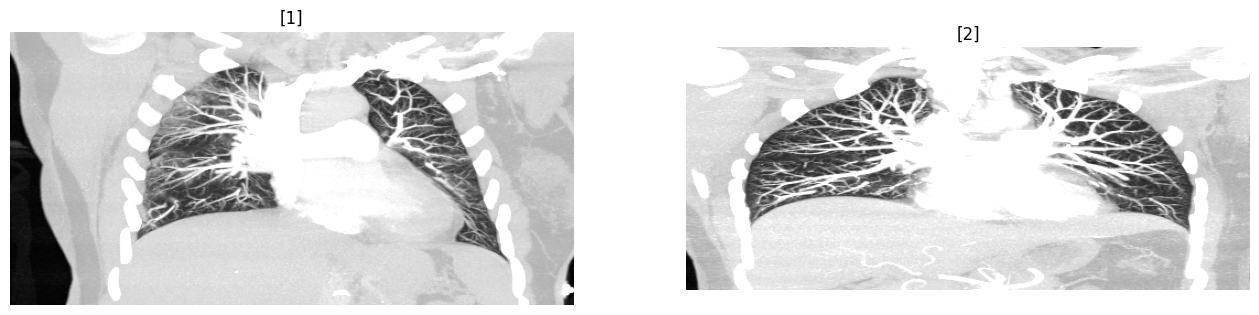

In [23]:
# Compute coronal MIP for the middle 40 slices of the patients
mip_image_a_coronal = compute_mid_mip(coronal_array_patient_a, 40)
mip_image_b_coronal = compute_mid_mip(coronal_array_patient_b, 40)

# Apply the windowing function to each MIP
mip_image_a_coronal_windowed = apply_window(mip_image_a_coronal, ds_middle_image)
mip_image_b_coronal_windowed = apply_window(mip_image_b_coronal, ds_middle_image)

# Display both images next to each other
plt.figure(figsize=(16, 6))

# Patient A's coronal MIP
plt.subplot(1, 2, 1)
plt.imshow(mip_image_a_coronal_windowed, cmap="gray")
plt.title("[1]")
plt.axis("off")

# Patient B's coronal MIP
plt.subplot(1, 2, 2)
plt.imshow(mip_image_b_coronal_windowed, cmap="gray")
plt.title("[2]")
plt.axis("off")

# Save and display the images
plt.savefig("MIP_coronal_A_B_Task_7_windowed.png", bbox_inches="tight", pad_inches=0.2, dpi=300)
plt.show()

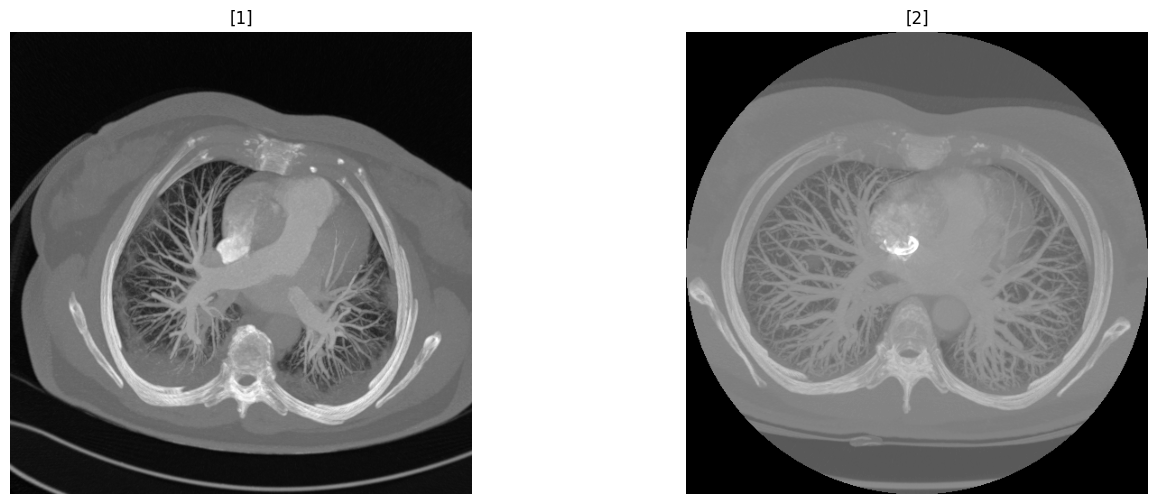

In [24]:
# Compute axial MIP for the middle 50 slices of the patients
mip_image_a_axial = compute_mid_mip(array_patient_a, 50)
mip_image_b_axial = compute_mid_mip(array_patient_b, 50)

# Apply the windowing function to each MIP
#mip_image_a_axial_windowed = apply_window(mip_image_a_axial, ds_middle_image)
#mip_image_b_axial_windowed = apply_window(mip_image_b_axial, ds_middle_image)
# --> does not improve lung visibility in my opinion so I didn't use it

# Display both images next to each other
plt.figure(figsize=(16, 6))

# Patient A's axial MIP
plt.subplot(1, 2, 1)
plt.imshow(mip_image_a_axial, cmap="gray")
plt.title("[1]")
plt.axis("off")

# Patient B's axial MIP
plt.subplot(1, 2, 2)
plt.imshow(mip_image_b_axial, cmap="gray")
plt.title("[2]")
plt.axis("off")

# Save and display the images
plt.savefig("MIP_axial_A_B_Task_8.png", bbox_inches="tight", pad_inches=0.2, dpi=300)
plt.show()

### Calculating the lung area in pixels

In [26]:
#COPIED & ADAPTED FROM: threshold-based approach in "precision-medicine-toolbox" (GitHub version)
#CHANGES MADE:
#1) Adjusted threshold from -600 HU to -400 HU.
#2) Removed 3D morphological steps to keep code minimal.

def segment_lung_slice(slice_array, intensity_threshold=-450):
    """
    Performs a simple threshold + connected components-based lung segmentation 
    on a single 2D CT slice.
    
    Args:
        slice_array (ndarray): 2D numpy array (one CT slice, in HU).
        intensity_threshold (int): Intensity threshold (in HU) for lung extraction.

    Returns:
        ndarray: Binary mask (shape = slice_array.shape) where 1=lung, 0=non-lung.
    """
    # 1) Convert to float32 for consistent operations
    slice_array = slice_array.astype(np.float32)
    
    # 2) Threshold for potential lung region (air-like)
    binary_mask = slice_array < intensity_threshold

    # 3) Remove small objects (noise)
    binary_mask = morphology.remove_small_objects(binary_mask, min_size=500)

    # 4) Label connected components
    labeled_mask = measure.label(binary_mask, background=0)

    # 5) Identify largest 3 connected components
    regions = measure.regionprops(labeled_mask)
    regions_sorted = sorted(regions, key=lambda r: r.area, reverse=True)
    top_3_regions = regions_sorted[:3]
    
    #Assuming the largest region is background (outside the body).
    #Therefore, only keeping the next two largest.

    if len(top_3_regions) < 3:
        # Fallback if there aren't enough regions
        lung_labels = [reg.label for reg in regions_sorted]
    else:
        # Skip the largest region, keep the next two
        lung_labels = [reg.label for reg in top_3_regions[1:]]

    # Build the mask from these labels
    lung_mask = np.isin(labeled_mask, lung_labels)

    # 6) (Optional) fill small holes
    lung_mask = morphology.remove_small_holes(lung_mask, area_threshold=1000)

    return lung_mask.astype(np.uint8)  # 1 = lung, 0 = background

In [27]:
def compute_lung_area_per_slice(slices_2d):
    """
    Computes lung area (in pixels) for each slice in a CT volume.

    Args:
        slices_2d (list of ndarray): A list of 2D numpy arrays (each is one CT slice).

    Returns:
        list of int: The area (in pixels) of the lung region for each slice.
    """
    lung_areas = []
    for slice_idx, slice_array in enumerate(slices_2d):
        # 1. Segment the slice
        mask = segment_lung_slice(slice_array)

        # 2. Calculate the area by summing mask pixels
        area = np.sum(mask)  # Each '1' in mask = 1 pixel
        lung_areas.append(area)

    return lung_areas

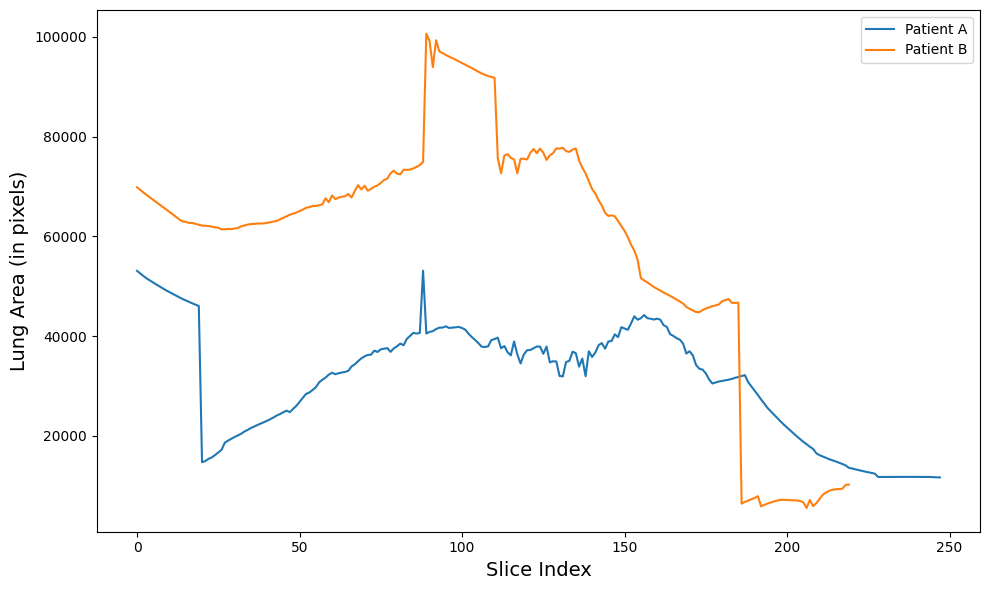

In [28]:
#Calculating lung areas per slice
lung_areas_a = compute_lung_area_per_slice(hu_patient_a)
lung_areas_b = compute_lung_area_per_slice(hu_patient_b)

#Visualising both patients' lung areas in a single graph
plt.figure(figsize=(10, 6))
plt.plot(lung_areas_a, label="Patient A")
plt.plot(lung_areas_b, label="Patient B")
plt.xlabel("Slice Index", fontsize=14)
plt.ylabel("Lung Area (in pixels)", fontsize=14)
plt.legend()

# Save and display the graph
plt.tight_layout()
plt.savefig("Comparison_lung_area_inpixels_Task_9).png", bbox_inches="tight", pad_inches=0.2, dpi=300)
plt.show()

### Testing
Additional visualisations of the intermediate steps to verify that the functions for the lung area are working as expected.

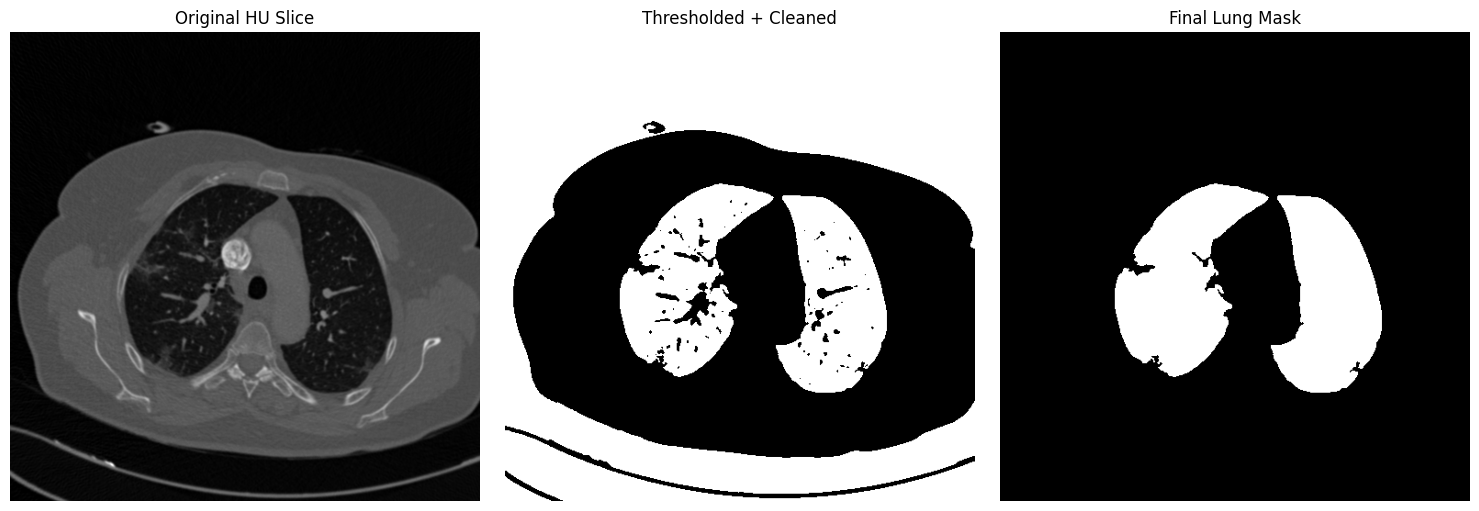

In [30]:
# 1. Choosing a slice index for visualisation
slice_index = 70

# 2. Retrieve the raw HU slice (ensure hu_patient_a[slice_index] is already in Hounsfield Units)
single_slice = hu_patient_a[slice_index]

# 3. Convert the slice to float32 (if not already) for consistent processing
slice_float = single_slice.astype(np.float32)

# 4. Thresholding: create a binary mask for air-like regions (potential lung)
threshold_val = -450
binary_mask = slice_float < threshold_val

# 5. Remove small objects to clean noise
binary_mask_cleaned = morphology.remove_small_objects(binary_mask, min_size=500)

# 6. Label connected components in the cleaned mask
labeled_mask = measure.label(binary_mask_cleaned, background=0)
regions = measure.regionprops(labeled_mask)

# 7. Sort regions by area, descending
regions_sorted = sorted(regions, key=lambda r: r.area, reverse=True)

# 8. Pick the top 3 largest regions
top_3_regions = regions_sorted[:3]

# 9. Exclude the largest region (often background), keep the next 2 as lungs
if len(top_3_regions) < 3:
    # If there are fewer than 3 regions total, just keep everything
    lung_labels = [r.label for r in regions_sorted]
else:
    # Skip the largest region => keep next two
    lung_labels = [r.label for r in top_3_regions[1:]]

# 10. Build a mask from these lung labels
lung_mask = np.isin(labeled_mask, lung_labels)

# 11. (Optional) fill small holes
lung_mask_filled = morphology.remove_small_holes(lung_mask, area_threshold=1000)

# 12. Convert final mask to uint8 (1 = lung, 0 = background)
final_lung_mask = lung_mask_filled.astype(np.uint8)


# Visualisation
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# (A) Show the original HU slice
ax[0].imshow(slice_float, cmap='gray')
ax[0].set_title("Original HU Slice")
ax[0].axis("off")

# (B) Show the thresholded & cleaned mask (before largest-region exclusion)
ax[1].imshow(binary_mask_cleaned, cmap='gray')
ax[1].set_title("Thresholded + Cleaned")
ax[1].axis("off")

# (C) Show the final lung mask (after excluding largest region & filling holes)
ax[2].imshow(final_lung_mask, cmap='gray')
ax[2].set_title("Final Lung Mask")
ax[2].axis("off")

plt.tight_layout()
plt.show()

In [31]:
#Printing the areas for each slice index
print("Patient A Lung Areas:")
for i, area_val in enumerate(lung_areas_a):
    print(f"Slice {i} - Lung area (pixels): {area_val}")

print("\nPatient B Lung Areas:")
for i, area_val in enumerate(lung_areas_b):
    print(f"Slice {i} - Lung area (pixels): {area_val}")

Patient A Lung Areas:
Slice 0 - Lung area (pixels): 53085
Slice 1 - Lung area (pixels): 52562
Slice 2 - Lung area (pixels): 52028
Slice 3 - Lung area (pixels): 51547
Slice 4 - Lung area (pixels): 51148
Slice 5 - Lung area (pixels): 50734
Slice 6 - Lung area (pixels): 50321
Slice 7 - Lung area (pixels): 49930
Slice 8 - Lung area (pixels): 49538
Slice 9 - Lung area (pixels): 49158
Slice 10 - Lung area (pixels): 48810
Slice 11 - Lung area (pixels): 48461
Slice 12 - Lung area (pixels): 48096
Slice 13 - Lung area (pixels): 47782
Slice 14 - Lung area (pixels): 47444
Slice 15 - Lung area (pixels): 47146
Slice 16 - Lung area (pixels): 46858
Slice 17 - Lung area (pixels): 46574
Slice 18 - Lung area (pixels): 46292
Slice 19 - Lung area (pixels): 46033
Slice 20 - Lung area (pixels): 14719
Slice 21 - Lung area (pixels): 14961
Slice 22 - Lung area (pixels): 15397
Slice 23 - Lung area (pixels): 15683
Slice 24 - Lung area (pixels): 16153
Slice 25 - Lung area (pixels): 16694
Slice 26 - Lung area (pixe

### Lung volume
Write a program to calculate the lung volume (in pixels) for each patient. Produce a table
of lung volume size for each patient and show this in the report.


Lung Volume Comparison (in pixels):
-----------------------------------
Patient A: 7714865.0 pixels
Patient B: 12858923.0 pixels


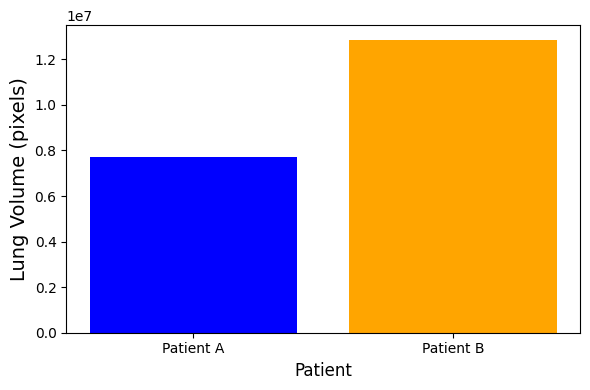

In [33]:
#Computing lung volumes for each patient
lung_volume_patient_a = sum(lung_areas_a)
lung_volume_patient_b = sum(lung_areas_b)

#Printing the results as a table format
print("\nLung Volume Comparison (in pixels):")
print("-----------------------------------")
print(f"Patient A: {lung_volume_patient_a} pixels")
print(f"Patient B: {lung_volume_patient_b} pixels")

#Comparing the two patients lung volume
plt.figure(figsize=(6, 4))
plt.bar(["Patient A", "Patient B"], [lung_volume_patient_a, lung_volume_patient_b], color=['blue', 'orange'])
plt.xlabel("Patient", fontsize=12)
plt.ylabel("Lung Volume (pixels)", fontsize=14)

# Save and display the graph
plt.tight_layout()
plt.savefig("Comparison_lung_volume_inpixels_Task_11.png", bbox_inches="tight", pad_inches=0.2, dpi=300)
plt.show()